# Training and visualizing MLPs on toy datasets

In this practical, we are going to learn how to train a simple feed forward neural network (aka Multi-Layer Perceptron or MLP) on a synthetic dataset and visualize the result.

First import the three libraries we will use: **torch**, **numpy** (as np) and **matplotlib.pyplot** (as plt).

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data generation

Then, create a function `create_checkerboard` that returns two pytorch Tensors: `X` of shape $(100,2)$ where $100$ is the number of data points and each point is drawn uniformly at random in $[-2,2]^2$, and `y` of shape $(100,2)$ where $y_i=(1,0)$ if $X_{i,1} \cdot X_{i,2} > 0$, and $y_i=(0,1)$ otherwise. The vectors $y_i$ are called **one-hot** encodings of the classes 0 and 1.

**IMPORTANT:** Always test the shape of your tensor with `print(X.shape)` to verify that your are computing the right quantity.



torch.Size([100, 2]) torch.Size([100, 2])


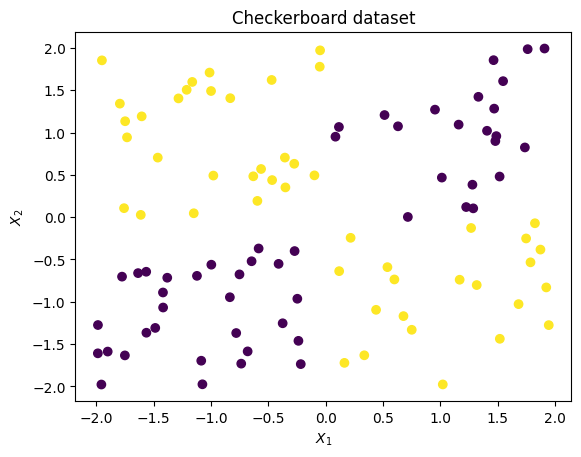

In [2]:
def create_checkerboard():
    X = torch.rand(100, 2) * 4 - 2
    y = torch.zeros(100, 2)
    x = X[:, 0] * X[:, 1]
    y[:, 0] = (x <= 0).float()
    y[:, 1] = (x > 0).float()
    return X, y

# Visualizing the dataset
X, y = create_checkerboard()
print(X.shape, y.shape)
plt.scatter(X[:, 0], X[:, 1], c=y[:,0])
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.title("Checkerboard dataset")
plt.show()

## Model creation

First, let's create a two layer MLP with ReLU activations, 2 inputs, 2 outputs, and 10 internal neurons using `torch.nn.Sequential`, `torch.nn.Linear` and `torch.nn.ReLU` (see documentation).

Verify that the model outputs a 2-dimensional vector for each input data point on the checkerboard dataset.

In [3]:
class MyModel(nn.Module):
    def __init__(self, nb_in = 2, nb_out = 2, nb_hidden = 10, nb_layers = 1):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(nb_in, nb_hidden)
        self.fcs = [nn.Linear(nb_hidden, nb_hidden) for _ in range(nb_layers-1)]
        self.fc2 = nn.Linear(nb_hidden, nb_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        for fc in self.fcs:
            x = self.relu(fc(x))
        x = self.fc2(x)
        return x

model = MyModel()

## Training pipeline

The following code is a routine to visualize the output of the network and loss during training. Note that `epoch` is the number of epochs of training, data is a tuple containing `X, y`, `model` is a neural network and `losses` is a list of loss values.

In [4]:
def visualize(epoch, data, model, losses):
    X, y = data
    # Creates a 2d grid
    xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 100), np.linspace(-2.5, 2.5, 100))

    # Uses the model to predict the class
    grid_tensor = torch.FloatTensor(np.stack([xx.ravel(), yy.ravel()], axis=1))
    with torch.no_grad():
        Z = model(grid_tensor)
        Z = Z[:,0] - Z[:,1]

    # Reshapes the predictions to fit the grid
    Z = Z.reshape(xx.shape)

    # Plots the output of the neural network
    fig = plt.figure(1, figsize=(10, 4))
    plt.subplot(1,2,1)
    CS = plt.contourf(xx, yy, Z, alpha=0.8)
    fig.colorbar(CS)
    plt.scatter(X[:, 0], X[:, 1], c=y[:,0])
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")
    plt.title(f"Classification with an MLP (epoch = {epoch})")

    # Plots the loss function
    plt.subplot(1,2,2)
    plt.plot(losses)
    plt.ylim([0,1])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. number of epochs")
    plt.tight_layout()
    plt.show()


Our objective is to push the model, for an input `X` to return an output that matches `y`. To do so we will minimize the **mean square error** $MSE = \frac{1}{N}\sum_{i=1}^N \|\mbox{model}(X_i) - y_i\|^2$ over the entire dataset using gradient descent.

Create a function `train(data, model, epochs)` that takes a dataset of inputs and outputs `X, y`, a neural network `model` and a number of `epochs`, and trains the neural network on the dataset for the specified number of epochs. You will need to create a loop over all epochs, in which you will:

1. Prepare gradient computations using `model.zero_grad()`
2. Compute the output of the `model` over the input data `X`
3. Compute the mean square error loss over the dataset.
4. Use `loss.backward()` to automatically compute the gradients of the loss wrt the model parameters.
5. Make one step of gradient descent by updating each parameter `p` in `model.parameters()` with the formula $p = p - \eta \nabla L(p)$ where $\eta=10^{-2}$ is the step-size and $L$ is the loss. Note that the gradient computed by `loss.backward()` is accessible in `p.grad`.
6. Once every 1000 epochs, visualize the output of the neural network and loss.


In [17]:
def MSE(y, y_pred):
    return ((y - y_pred)**2).mean()

In [34]:
def train(data, model, epochs, lr = 1e-3):
    X, y = data
    losses = []
    #loss is binary cross entropy
    loss_fn = nn.BCEWithLogitsLoss()
    loss_fn = MSE
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in tqdm(range(epochs)):
        model.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y, y_pred)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    #find accuracy
    y_pred = model(X)
    y_pred = torch.sigmoid(y_pred)
    argmax = torch.argmax(y_pred, dim=1)
    accuracy = (argmax == y).float().mean()

    visualize(epoch, data, model, losses)

Finally, train your MLP on the checkerboard dataset for 10000 epochs. Is it predicting the correct classes? Try with 2, 10, and 100 neurons in the internal layer.

Number of hidden units: 2


100%|██████████| 1001/1001 [00:00<00:00, 1070.86it/s]


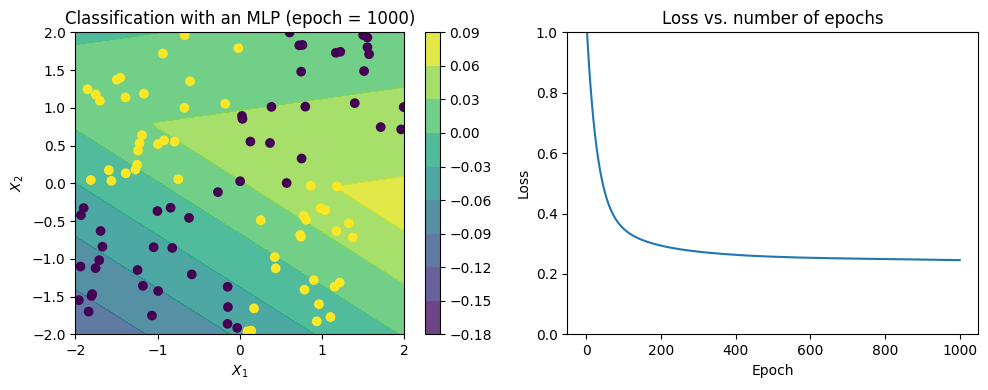

Number of hidden units: 10


100%|██████████| 1001/1001 [00:00<00:00, 1052.80it/s]


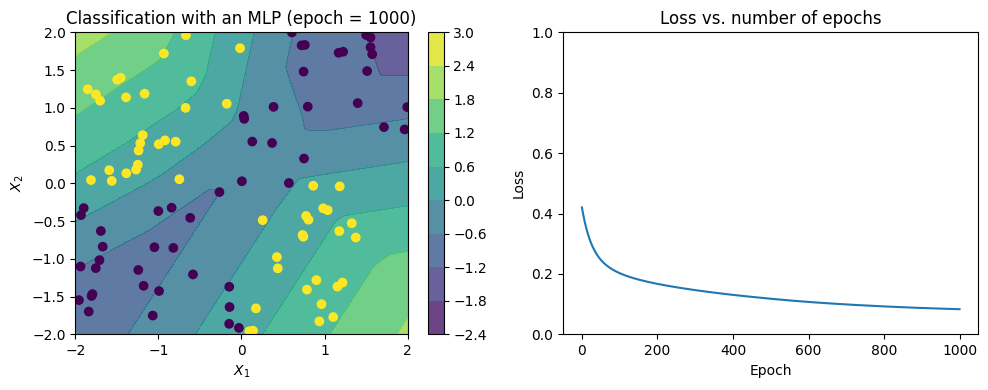

Number of hidden units: 100


100%|██████████| 1001/1001 [00:01<00:00, 946.94it/s]


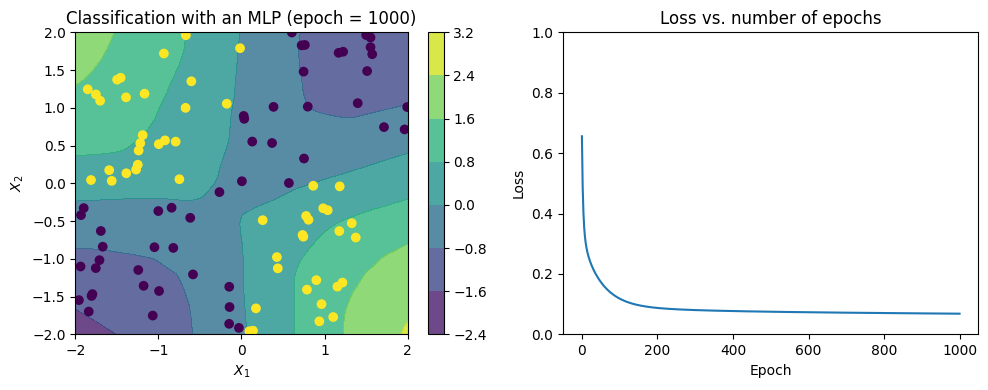

In [52]:
nb_hiddens = [2, 10, 100]
for nb_hidden in nb_hiddens:
    model = MyModel(nb_hidden=nb_hidden)
    print(f"Number of hidden units: {nb_hidden}")
    train((X, y), model, 1001)

## Harder dataset

The following code create a more challenging dataset consisting of two intertwined spirals.

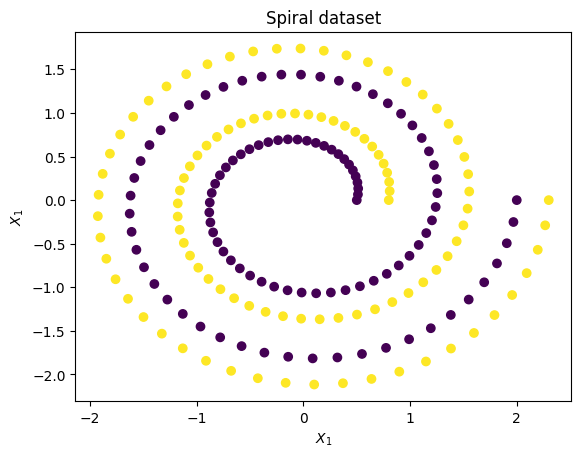

In [28]:
def create_spiral():
    # Créez une spirale
    theta = np.linspace(0, 4 * np.pi, 100)
    r = np.linspace(0.5, 2, 100)
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    # Créez une autre spirale avec une classe différente
    theta = np.linspace(0, 4 * np.pi, 100)
    r = np.linspace(0.5, 2, 100) + 0.3
    x2 = r * np.cos(theta)
    y2 = r * np.sin(theta)

    # Fusionnez les deux ensembles de données
    X = np.vstack((np.hstack((x, x2)), np.hstack((y, y2)))).T
    y = np.hstack((np.zeros(100), np.ones(100)))

    # De Numpy arrays à PyTorch Tensors
    X = torch.FloatTensor(X)
    y = torch.FloatTensor([y,1-y]).T

    return X, y

# Visualisez les données
X, y = create_spiral()
plt.scatter(X[:, 0], X[:, 1], c=y[:,0])
plt.xlabel("$X_1$")
plt.ylabel("$X_1$")
plt.title("Spiral dataset")
plt.show()

Train your model (craete a new model to reinitialize the parameters) on the spiral dataset for 50000 epochs. Is it predicting the correct classes? Try increasing the number of neurons.

Number of hidden units: 1000


100%|██████████| 1001/1001 [00:02<00:00, 487.41it/s]


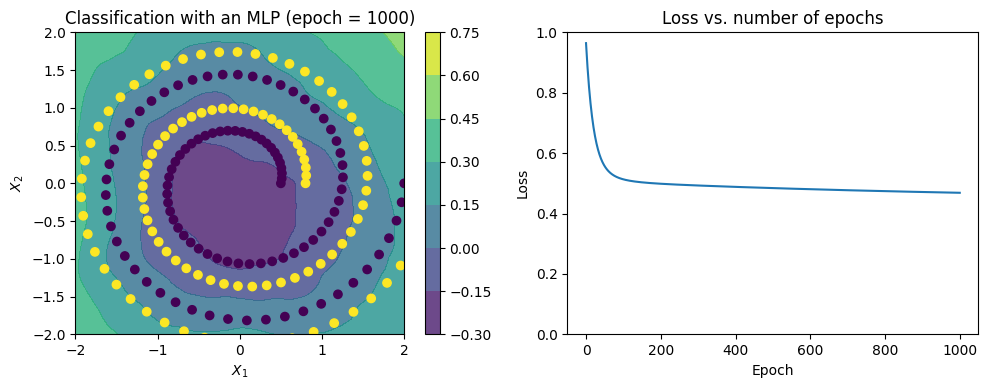

In [35]:
nb_hidden = 1000
model = MyModel(nb_hidden=nb_hidden)

print(f"Number of hidden units: {nb_hidden}")
train((X, y), model, 1001, lr = 1e-4)

Number of hidden units: 2


100%|██████████| 1001/1001 [00:00<00:00, 1017.69it/s]


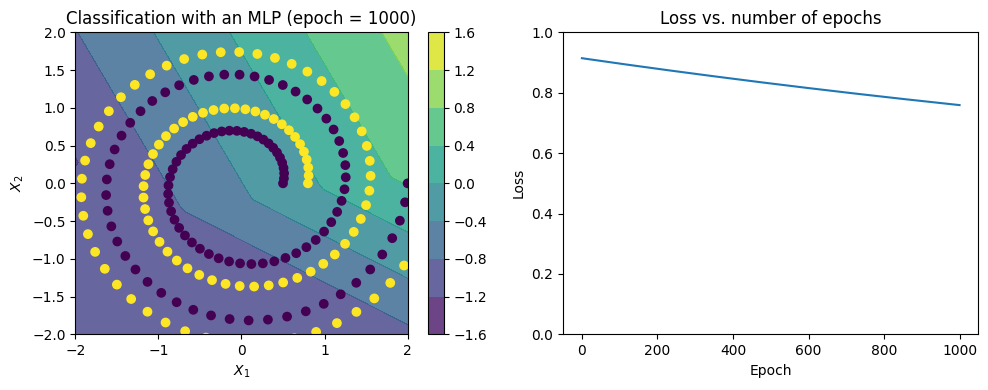

Number of hidden units: 10


100%|██████████| 1001/1001 [00:01<00:00, 996.16it/s]


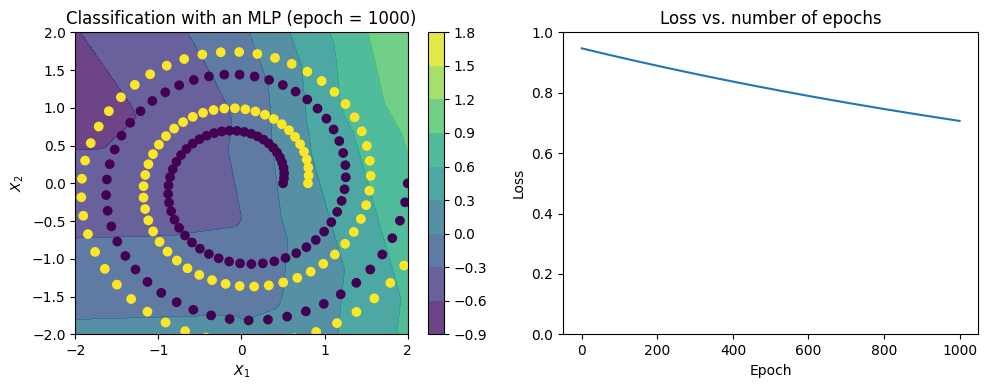

Number of hidden units: 100


100%|██████████| 1001/1001 [00:01<00:00, 817.47it/s]


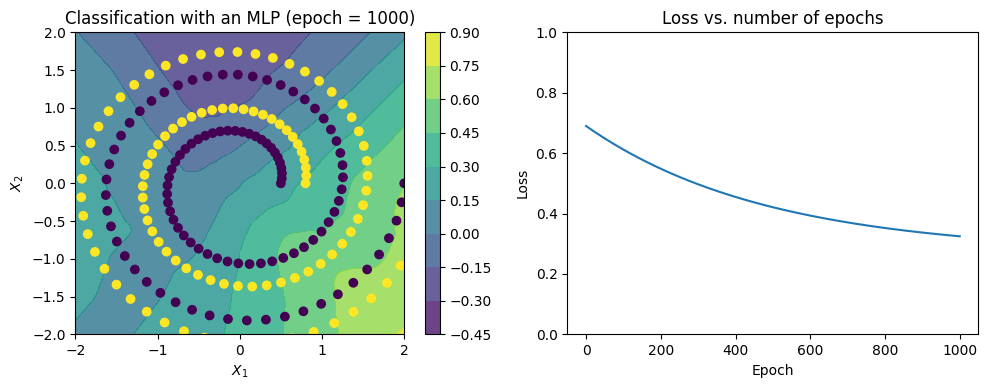

Number of hidden units: 1000


100%|██████████| 1001/1001 [00:01<00:00, 545.76it/s]


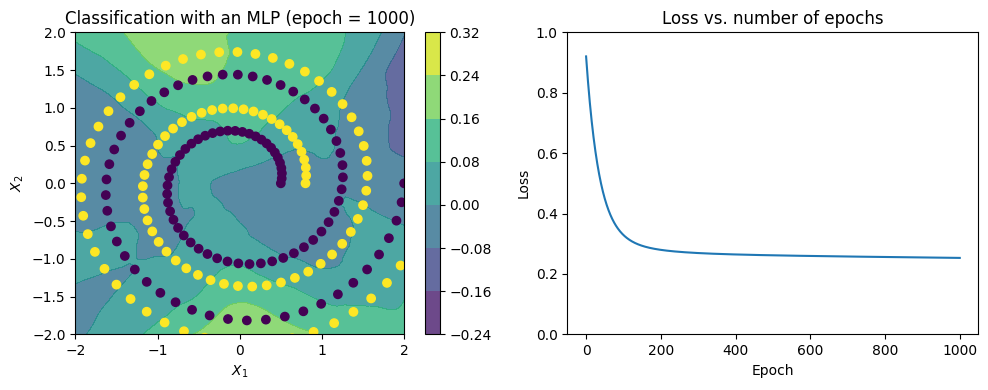

In [8]:
nb_hiddens = [2, 10, 100, 1000]
for nb_hidden in nb_hiddens:
    model = MyModel(nb_hidden=nb_hidden)
    print(f"Number of hidden units: {nb_hidden}")
    train((X, y), model, 1001)

Number of hidden units: 2


  0%|          | 0/1001 [00:00<?, ?it/s]

100%|██████████| 1001/1001 [00:02<00:00, 402.60it/s]


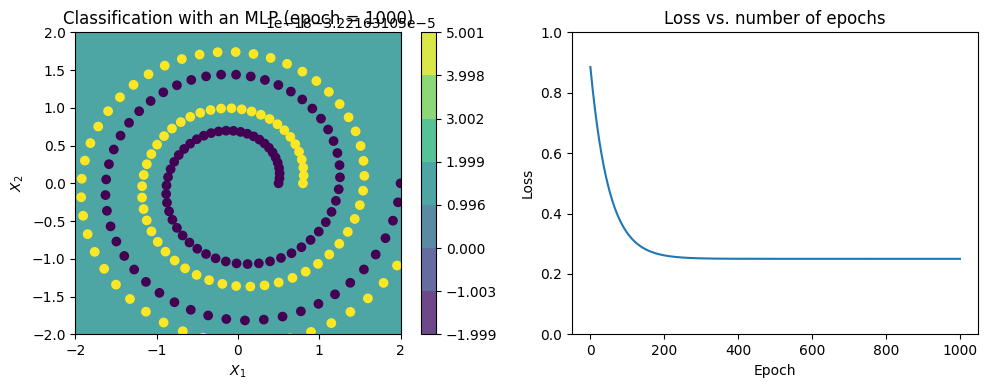

Number of hidden units: 10


100%|██████████| 1001/1001 [00:02<00:00, 352.70it/s]


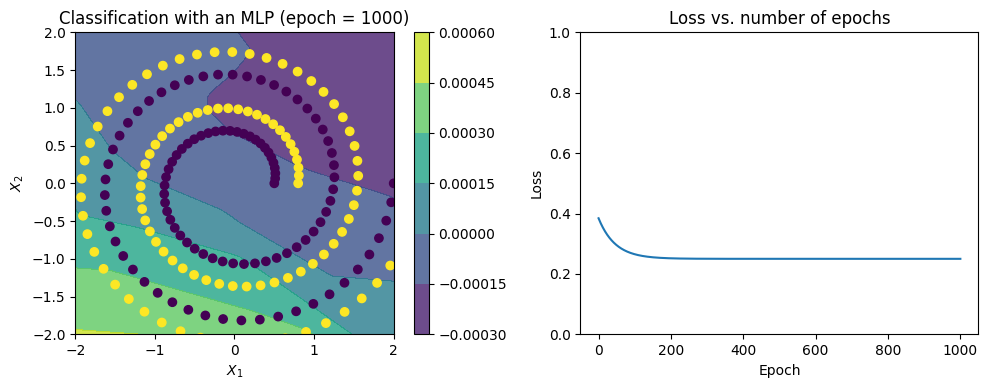

Number of hidden units: 100


100%|██████████| 1001/1001 [00:08<00:00, 124.21it/s]


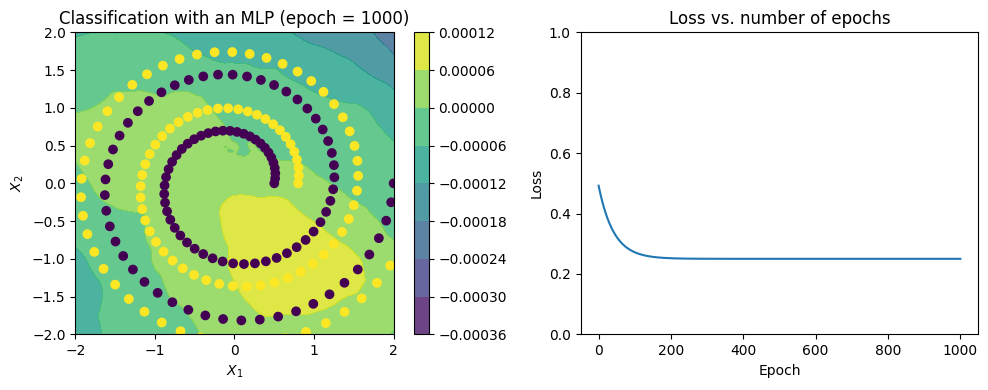

Number of hidden units: 1000


 20%|██        | 205/1001 [00:41<02:40,  4.96it/s]


KeyboardInterrupt: 

In [64]:
nb_hiddens = [2, 10, 100, 1000]
for nb_hidden in nb_hiddens:
    model = MyModel(nb_hidden=nb_hidden, nb_layers=10)
    print(f"Number of hidden units: {nb_hidden}")
    train((X, y), model, 1001)